# 🧑‍🎓 Students:

- Nikita Kiselov
- Marwan Mashra 

# Audio Signal Declipping

This is an implementation of the : relaxed ISTA algoritm presented in the paper <a href="https://hal.archives-ouvertes.fr/hal-01002998/document">Audio Declipping with Social Sparsity</a> in 2014 by Kai Siedenburg, Matthieu Kowalski and Monika Dörfler.

## Imports

In [1]:
from scipy.io import wavfile
from IPython.display import Audio
from scipy import signal
import numpy as np
from scipy.optimize import fsolve, minimize
from pathlib import Path
import matplotlib.pyplot as plt
import keyboard
from time import time


## Load the audio

The audio sound used in this notebook could be found here <a href="http://hebergement.universite-paris-saclay.fr/mkowalski/AI/data/music.wav">music.wav<a>

In [2]:
data_folder = "sounds"
audio_file = "music.wav"

data_path = Path(data_folder)
rate, data = wavfile.read(data_path / audio_file)
length_signal = len(data)
print(min(data))


-31904


## Clip the audio

Here we'll clip the audio controlling the SDR. SDR (Signal-to-Distortion Ratio) is a measure of the quality of a reconstructed signal. We can use it to assess the performance of our signal reconstruction algorithm. It's defined as the ratio between the original signal and the reconstruction error. For a given original signal $S_{original}$ and a reconstructed signal $S_{rec}$, the SDR can be computed as following:

$$
\text{SDR}(S_{original}, S_{rec}) = 20 \times \log{\frac{|| S_{original} || }{ || S_{original} - S_{rec} ||}}


$$

In [3]:
def sdr(original_signal, reconstructed_signal):
    """computes the sdr of a reconstructed signal

    Args:
        original_signal (ndarray): the original signal
        reconstructed_signal (ndarray): the reconstructed signal

    Returns:
        float: the sdr of the reconstructed signal
    """
    sdr_val = 20 * np.log10(
        np.linalg.norm(original_signal)
        / np.linalg.norm(original_signal - reconstructed_signal)
    )
    return sdr_val


Now, in order to clip the signal to the desired SDR, we use the function fsolve which allows us to find a threshold of the amplitude that makes the difference between the signal's true SDR and the desired SDR as close as possible to 0  

In [4]:
def hard_clip(signal, threshold):
    """clips a signal given a threshold

    Args:
        signal (ndarray): the signal to be clipped
        threshold (float): the threshold

    Returns:
        ndarray: the clipped signal
        dict: the masks
    """
    t_min, t_max = -threshold, threshold
    if min(signal) >= t_min and max(signal) <= t_max:
        print("Clipping range too large. No clipping will occur!")
    masks = {}
    masks["M_c"] = (signal > t_max) | (signal < t_min)
    masks["M_r"] = ~masks["M_c"]
    clipped = signal.clip(min=t_min, max=t_max)

    return clipped, masks


def clip_sdr(signal, desired_sdr):
    """clips a signal given an SDR

    Args:
        signal (ndarray): the signal to be clipped
        desiredSDR (float): the desired sdr of the clipped signal

    Returns:
        ndarray: the clipped signal
        dict: the masks
        float: the clipping threshold of the amplitude
        float: the true sdr of the clipped signal (very close to the desiredSDR)
    """
    # Difference function
    def diff_sdr(T):
        return sdr(signal, hard_clip(signal, T)[0]) - desired_sdr

    clipping_threshold = fsolve(diff_sdr, 0)
    diff_from_desired_sdr = diff_sdr(clipping_threshold)
    True_sdr = desired_sdr + diff_from_desired_sdr
    data_clipped, masks = hard_clip(signal, clipping_threshold)

    plt.plot(data)
    plt.plot(data_clipped, c="0.8")
    plt.show()

    return data_clipped, masks, clipping_threshold, True_sdr



Now we clip the audio signal to an SDR of 15 

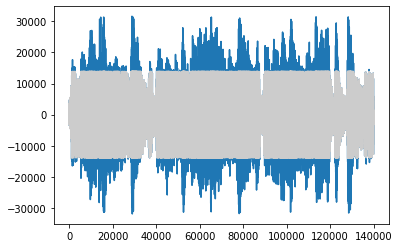

In [5]:
desired_sdr = 15
data_clipped, masks, clipping_threshold, true_sdr = clip_sdr(data, desired_sdr)

We notice the difference between the clipped signal (orange) and the original signal blue. The goal now will be to recover the original signal, given the clipped one.

## Gabor Transform 

In the paper, they choose the Gabor transform for a short-Time Fourier Transform. In order to use the Gabor transform in python, we could use the package **ltfatpy** that offers the function ltfatpy.gabor.dgtreal for Discrete Gabor transform for real signals. However, this package is old and not well supported for windows (and barley still alive 🤣). Therefore, we decided to use the short-Time Fourier Transform from SciPy. 


In [5]:
class Gab:
    def __init__(
        self,
        window_type,
        window_length,
        window_shift,
        num_freq_channels,
        length_signal,
        rate,
    ):

        self.window = window_type
        self.nperseg = window_length
        self.noverlap = window_length - window_shift
        self.nfft = num_freq_channels
        self.length_signal = length_signal
        self.rate = rate

    def analysis(self, x):
        """short time fourier transform"""
        _, _, Zxx = signal.stft(
            x,
            self.rate,
            window=self.window,
            nperseg=self.nperseg,
            noverlap=self.noverlap,
            nfft=self.nfft,
        )
        return Zxx

    def synthesis(self, x):
        """inverse short time fourier transform"""
        _, f = signal.istft(
            x,
            self.rate,
            window=self.window,
            nperseg=self.nperseg,
            noverlap=self.noverlap,
            nfft=self.nfft,
        )
        return f[: self.length_signal]

In the paper, they use a tight Gabor frame which is based on a **hann** window of size 1024 and with a time-shift of 256 samples. We follow those settings in our experiments.

In [6]:
window_type = "hann"  # window type
window_length = 1024  # window length
window_shift = window_length / 4  # window shift    (a)
num_freq_channels = 2 * window_length  # number of frequency channels  (M)
gab = Gab(
    window_type=window_type,
    window_length=window_length,
    window_shift=window_shift,
    num_freq_channels=num_freq_channels,
    length_signal=length_signal,
    rate = rate
)


## Shrinkage

In the paper, they test the four following shrinkage (thresholding) strategies:
1. Lasso : $$\tilde{\alpha}_{tf} = \mathbb{S}^{L}_{\lambda} = \alpha_{tf} (1 - \frac{\lambda}{|\alpha_{tf}|})^{+}$$
2. WGL (Windowed Group-Lasso): $$\tilde{\alpha}_{tf} = \mathbb{S}^{L}_{\lambda} = \alpha_{tf} (1 - \frac{\lambda}{\sqrt{\sum_{t' \in \mathcal{N(t)}}{|\alpha_{t'f}|^2}}})^{+}$$
3. EW (Empirical Wiener): $$\tilde{\alpha}_{tf} = \mathbb{S}^{L}_{\lambda} = \alpha_{tf} (1 - \frac{\lambda^2}{|\alpha_{tf}|^2})^{+}$$
4. PEW (Persistent Empirical Wiener) : $$\tilde{\alpha}_{tf} = \mathbb{S}^{L}_{\lambda} = \alpha_{tf} (1 - \frac{\lambda^2}{\sum_{t' \in \mathcal{N(t)}}{|\alpha_{t'f}|^2}})^{+}$$

We see that those 4 shrinkage operators have two different key differentiator :

<br>

1. **Energy preserving:**

    Operators like Lasso and WGL leads to a loss of energy in the estimated signal, whereas the usage of operator like EW and PEW preserve the energy in the big coefficients. 

<br>

2. **Persistence :**

    Operators like WGL and PEW exploit the persistence-properties of signal components through time neighborhood systems. The idea here is that for a give $t$, we sum over its time neighborhood $\sum_{t' \in \mathcal{N(t)}}{|\alpha_{t'f}|}$ up to a certain size. According to the results in this paper, in section 4.3. Choice of the neighborhood, smaller neighborhood like 3 are more suited for speech audio signal, whereas bigger size neighborhood like 5 or 7 are better for music signals. Since we're using music signals here, we'll be testing bigger size neighborhood to see if we'll end up with a similar conclusion. Few notes on the implementation of the neighborhood in the function *get_neighborhood*:

    * We'll need to normalize by the norm of the neighborhood.
    * We'll be using a 2D convolution as an elegant way to implement the sliding window mechanism in the neighborhoods.

In [7]:
def get_neighborhood(alpha, neighborhood_size):
    neigh = np.ones((neighborhood_size, 1))
    neigh = neigh / np.linalg.norm(neigh, ord=1)
    sigma = np.abs(alpha) ** 2
    sigma = signal.convolve2d(sigma, neigh, mode="same")
    return sigma


def lasso_shrink(alpha, lamda, neighborhood_size=None):
    return alpha * (1 - lamda / np.abs(alpha)).clip(min=0)


def wgl_shrink(alpha, lamda, neighborhood_size):
    sigma = get_neighborhood(alpha, neighborhood_size)
    return alpha * (1 - lamda / np.sqrt(sigma)).clip(min=0)


def ew_shrink(alpha, lamda, neighborhood_size=None):
    return alpha * (1 - (lamda / np.abs(alpha)) ** 2).clip(min=0)


def pew_shrink(alpha, lamda, neighborhood_size):
    sigma = get_neighborhood(alpha, neighborhood_size)
    return alpha * (1 - lamda**2 / sigma).clip(min=0)

## Evaluation

We'll also be comparing the SNR of the clipped and declipped signals to asses the results of the declipping algorithm. In the paper, they also propose the $\text{SNR}_m$ to evaluate the declipped signal. $\text{SNR}_m$ is the SNR (Signal-to-Noise Ratio) of the missing (clipped) samples. It can be computed as following:
$$
{SNR}_m(S_{clipped}, S_{rec}, M^c) = 20 \times \log{\frac{|| M^c S_{clipped} ||}{ || M^c (S_{clipped} - S_{rec}) ||}}
$$

The smaller the $\text{SNR}_m$, the more we were able to recover from the clipped signal. Therefore, our goal is to minimize it.

In [8]:
def snr_miss(signal_clipped, signal_reconstructed, masks):
    """computes the SNR of the missing samples

    Args:
        signal_clipped (ndarray): the clipped signal
        signal_reconstructed (ndarray): the reconstructed declipped signal
        masks (dict): the masks

    Returns:
        float: the SNR of the missing samples 
    """
    return 20 * np.log10(
        np.linalg.norm(masks["M_c"] * signal_clipped) / np.linalg.norm(masks["M_c"] * (signal_clipped - signal_reconstructed))
    )


def snr(signal_original, signal_processed):
    """computes the SNR

    Args:
        signal_original (ndarray): the original signal
        signal_processed (ndarray): the processed signal (clipped, declipped...etc)

    Returns:
        float: the SNR
    """
    return 20 * np.log10(
        np.linalg.norm(signal_original) / np.linalg.norm(signal_original - signal_processed)
    )

## Relaxed ISTA Algorithm

In [59]:
def declip(
    data_clipped,
    data=data,
    masks=masks,
    true_sdr=true_sdr,
    clipping_threshold=clipping_threshold,
    shrinkage="L",
    neighborhood_size=7,
    number_lambdas=10,
    start_lambda=-1,
    end_lambda=-4,
    inner_iterations=500,
    convergence_factor=1e-4,
    delta=1,
    iter_limit=None,
    stop_with_q=True,
    verbose=True,
):
    """apply the declipping algorithm

    Args:
        data_clipped (ndarray): the clipped data
        data (ndarray, optional): the original data (used for evaluation purpose only). Defaults to data.
        masks (dict, optional): the masks of the clipped data. Defaults to masks.
        shrinkage ({'L', 'WGL', 'EW', 'PEW'}, optional): the type of shrinkage operator to use. Defaults to "L".
        neighborhood_size (int, optional): the size of the time neighborhood. Only used for WGL and PEW shrinkage.Defaults to 7.. Defaults to 7.
        number_lambdas (int, optional): number of thresholds lambda. Defaults to 10.
        start_lambda (int, optional): the start of the lambda values interval in a log scale. Defaults to -1.
        end_lambda (int, optional): the end of the lambda values interval in a log scale. Defaults to -4.
        inner_iterations (int, optional): max number of iterations for each lambda. Defaults to 500.
        convergence_factor (float, optional): the minimum difference for convergence. Defaults to 1e-4.
        delta (int, optional): the delta in the algorithm. Defaults to 1.
        iter_limit (int, optional): the maximum number of total iterations to preform. The algorithm continues until convergence if None. Defaults to None.
        stop_with_q (bool, optional): stop the iterations by holding q on the keyboard. Defaults to True.
        verbose (bool, optional): print results at each iteration. Defaults to True.

    Returns:
        ndarray: the reconstructed (declipped) audio signal
        dict: all the stats of the declipping reports
    """

    time_freq_data_clipped = gab.analysis(data_clipped)

    alpha = np.zeros_like(time_freq_data_clipped)
    z = alpha.copy()

    threshold = {
        "l": lasso_shrink,
        "wgl": wgl_shrink,
        "ew": ew_shrink,
        "pew": pew_shrink,
    }[shrinkage.lower()]

    data_rec = data_clipped.copy()

    iter_cnt = 0
    stop = False
    t0 = time()
    M_r = masks["M_r"]
    M_c = masks["M_c"]
    y_r = M_r * data_clipped
    theta_clip = M_c * data_clipped

    if stop_with_q:
        print("Hold q to stop...")
        
    for i, lamda in enumerate(np.logspace(start_lambda, end_lambda, number_lambdas)):
        for k in range(1, inner_iterations + 1):
            data_rec_old = data_rec
            iter_cnt = iter_cnt + 1

            # forward step
            alpha_old = alpha.copy()

            phi_z = gab.synthesis(z)

            r1 = M_r.T * (y_r - M_r * phi_z)

            g1 = -gab.analysis(r1)  # phi*

            r2 = M_c.T * (theta_clip - M_c * phi_z)
            r2[np.abs(phi_z) > clipping_threshold] = 0
            g2 = -gab.analysis(r2)  # phi*

            # thresholding step
            alpha = threshold(
                z - (g1 + g2) / delta,
                lamda / delta,
                neighborhood_size=neighborhood_size,
            )

            # relaxation step
            gamma = (k - 1) / (k + 5)
            z = alpha + gamma * (alpha - alpha_old)

            data_rec = gab.synthesis(alpha)  # phi
            if np.linalg.norm(data_rec_old - data_rec) < convergence_factor:
                break

            if verbose:
                sdr_rec = sdr(data, data_rec)
                snr_m = snr_miss(data_clipped, data_rec, masks)
                print(
                    f"({i+1}/{number_lambdas}) lambda = {lamda:.5f} -- it = {k} -- SDR = {sdr_rec} -- dSDR = {sdr_rec-true_sdr} -- SNRm = {snr_m}",
                    end="\r",
                    flush=True,
                )

            if stop_with_q and keyboard.is_pressed("q"):
                stop = True

            if iter_limit is not None and iter_cnt > iter_limit:
                stop = True

            if stop:
                break

        if stop:
            break

    t1 = time()

    if verbose:
        print(
            f"({i+1}/{number_lambdas}) lambda = {lamda:.5f} -- it = {k} -- SDR = {sdr_rec} -- dSDR = {sdr_rec-true_sdr} -- SNRm = {snr_m}"
        )

    print(f"###### Declipping report (shrinkage={shrinkage.upper()}) ######")
    sdr_clip = sdr(data, data_clipped)
    sdr_rec = sdr(data, data_rec)
    snr_m = snr_miss(data_clipped, data_rec, masks)
    snr_clip = snr(data, data_clipped)
    snr_rec = snr(data, data_rec)
    runtime = int(t1 - t0)
    if runtime <= 60:
        runtime = f"{runtime}s"
    else:
        runtime = f"{runtime//60}m{runtime%60}s"
    report = {
        "snr_miss": snr_m,
        "snr_clip": snr_clip,
        "snr_rec": snr_rec,
        "snr_gain": (snr_rec - snr_clip),
        "sdr_clip": sdr_clip,
        "sdr_rec": sdr_rec,
        "sdr_gain": (sdr_rec - sdr_clip),
        "runtime": runtime,
    }
    print(f"Runtime: {report['runtime']}")
    print(f"SNR of the clipped signal = {report['snr_clip']:.3f} dB.")
    print(f"SNR of the reconstructed signal = {report['sdr_rec']:.3f} dB.")
    print(f"SNR gain = {report['snr_gain']:.3f} dB.")
    print(f"SNR miss = {report['snr_miss']:.3f} dB.")
    print(f"SDR of the clipped signal = {report['sdr_clip']:.3f} dB.")
    print(f"SDR of the reconstructed signal = {report['sdr_rec']:.3f} dB.")
    print(f"SDR gain = {report['sdr_gain']:.3f} dB.")

    plt.plot(data)
    plt.plot(data_rec)
    plt.plot(data_clipped, c="0.8")

    plt.show()

    return data_rec, report


## Experiments

### Testing all shrinkage operators

Let's try all 4 shrinkage operators and compare their results

Hold q to stop...
(10/10) lambda = 0.00010 -- it = 500 -- SDR = 19.688125523176797 -- dSDR = 4.688125523176797 -- SNRm = 14.6143732544586328
###### Declipping report (shrinkage=L) ######
Runtime: 15m6s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 19.688 dB.
SNR gain = 4.688 dB.
SNR miss = 14.614 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 19.688 dB.
SDR gain = 4.688 dB.


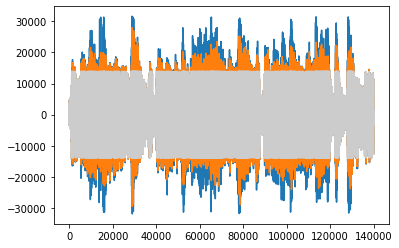

In [27]:
data_rec_l, report_l = declip(data_clipped, shrinkage="L", stop_with_q=False)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 500 -- SDR = 19.265086446112797 -- dSDR = 4.265086446112797 -- SNRm = 14.7901702154602793
###### Declipping report (shrinkage=WGL) ######
Runtime: 15m48s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 19.265 dB.
SNR gain = 4.265 dB.
SNR miss = 14.790 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 19.265 dB.
SDR gain = 4.265 dB.


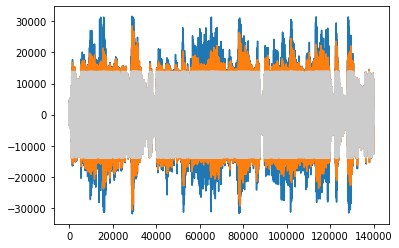

In [28]:
data_rec_wgl, report_wgl = declip(data_clipped, shrinkage="WGL", stop_with_q=False)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 500 -- SDR = 15.27821461163166 -- dSDR = 0.2782146116316593 -- SNRm = 31.84964982733719657
###### Declipping report (shrinkage=EW) ######
Runtime: 11m36s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 15.278 dB.
SNR gain = 0.278 dB.
SNR miss = 31.850 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 15.278 dB.
SDR gain = 0.278 dB.


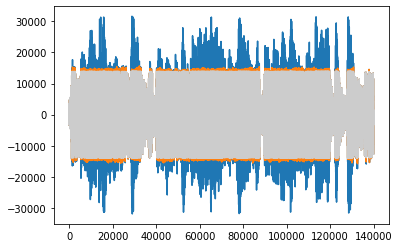

In [39]:
data_rec_ew_lambda_small, report_ew_lambda_small = declip(
    data_clipped, shrinkage="EW", stop_with_q=False
)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 9 -- SDR = 15.340999289108792 -- dSDR = 0.34099928910879207 -- SNRm = 28.39377308882095754
###### Declipping report (shrinkage=PEW) ######
Runtime: 12m32s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 15.341 dB.
SNR gain = 0.341 dB.
SNR miss = 28.394 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 15.341 dB.
SDR gain = 0.341 dB.


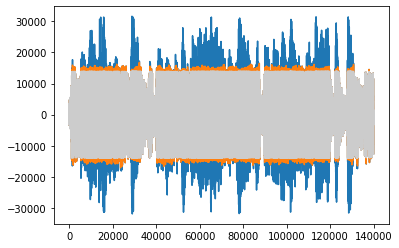

In [38]:
data_rec_pew_lambda_small, report_pew_lambda_small = declip(
    data_clipped, shrinkage="PEW", stop_with_q=False
)


We notice that results of L and WGL are good. However, the EW and PEW operators seem to preform terribly. This is due to the fact that we have $\lambda^2$ in the formula. Since $\lambda$ takes values from 0.1 to 0.0001, putting it to the power of 2 will mean having lambda values that are way too small. We conclude that  we can't use the same lambda values range for EW and PEW as for L and WGL. We need them to be bigger !  

### Playing with lambda values

Here, we'll experiment with different starting values for lambda values ranges to see if that will help EW/PEW preform better or even outperform L/WGL. Remember that the start_lambda is in log scale, i.e. start_lambda=0 means a starting value of 1.0, start_lambda=1 means a starting value of 10.0...etc. 

Hold q to stop...
(10/10) lambda = 0.00010 -- it = 500 -- SDR = 18.835454633034793 -- dSDR = 3.835454633034793 -- SNRm = 15.8952009557218077
###### Declipping report (shrinkage=EW) ######
Runtime: 13m6s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 18.835 dB.
SNR gain = 3.835 dB.
SNR miss = 15.895 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 18.835 dB.
SDR gain = 3.835 dB.


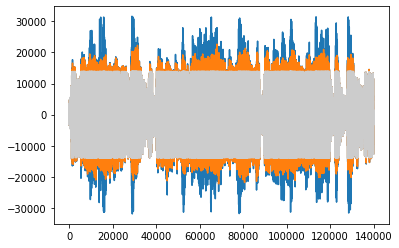

In [29]:
data_rec_ew, report_ew = declip(
    data_clipped, shrinkage="EW", start_lambda=0, stop_with_q=False
)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 49 -- SDR = 20.90030706873491 -- dSDR = 5.900307068734911 -- SNRm = 12.504866481987147785
###### Declipping report (shrinkage=PEW) ######
Runtime: 13m30s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 20.900 dB.
SNR gain = 5.900 dB.
SNR miss = 12.505 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 20.900 dB.
SDR gain = 5.900 dB.


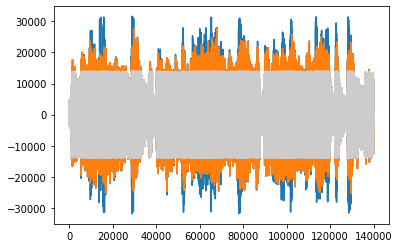

In [30]:
data_rec_pew, report_pew = declip(
    data_clipped, shrinkage="PEW", start_lambda=0, stop_with_q=False
)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 68 -- SDR = 29.92229459726564 -- dSDR = 14.92229459726564 -- SNRm = 9.1265556759081193527
###### Declipping report (shrinkage=PEW) ######
Runtime: 12m54s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 29.922 dB.
SNR gain = 14.922 dB.
SNR miss = 9.127 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 29.922 dB.
SDR gain = 14.922 dB.


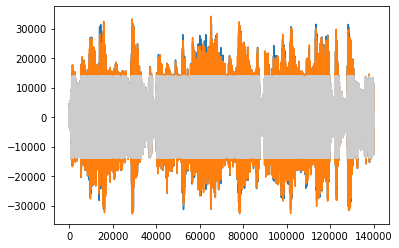

In [37]:
data_rec_pew_lambda1, report_pew_lambda1 = declip(
    data_clipped, shrinkage="PEW", start_lambda=1, stop_with_q=False
)


(10/10) lambda = 0.00010 -- it = 500 -- SDR = 29.670408003545315 -- dSDR = 14.670408003545795 -- SNRm = 9.09020011066123418
###### Declipping report (shrinkage=PEW) ######
Runtime: 16m17s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 29.670 dB.
SNR gain = 14.670 dB.
SNR miss = 9.090 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 29.670 dB.
SDR gain = 14.670 dB.


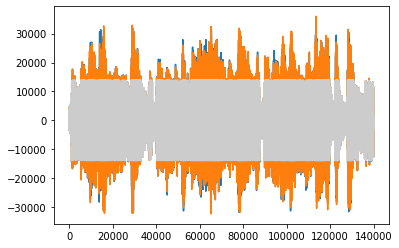

In [86]:
data_rec_pew_lambda2, report_pew_lambda2 = declip(
    data_clipped, shrinkage="PEW", start_lambda=2, stop_with_q=False
)


We notice the following:

* As we suspected, the lambda starting value was the main reason both EW/PEW underperformed in comparison with L/WGL, EW/PEW need a bigger starting value.
* When using a lambda starting value of 0 (in log scale), we get similar performance to L/WGL. We see that EW slightly underperformed L/WGL, whereas PEW slightly overperform them. However, when using a lambda starting value of of 1, PEW overperform L/WGL by a massive different and almost recover the original signal completely. 
* When going above lambda starting value of 1, and trying 2 instead, we don't see any improvement. We actually see a slight decrease in performance as well as an increase in Runtime.

We conclude that PEW with a lambda starting value of 1 (in log scale, 10.0 in decimals) yields the best performance until now.

### Testing different neighborhood size

In the paper, they recommend neighborhood of size 5 or 7 for audio signal with instruments, which is our case with the music audio we're working with. It's true that we did obtain really good results with a neighborhood of size 7. However, in this section we'll experiment to see how going with bigger neighborhood size might effect the results. We'll try neighborhoods of size 9, 11, 13, and 19, and compare those results to 7.

Hold q to stop...
(10/10) lambda = 0.00010 -- it = 39 -- SDR = 20.94137647976652 -- dSDR = 5.941376479766522 -- SNRm = 12.42322095766908666
###### Declipping report (shrinkage=PEW) ######
Runtime: 13m57s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 20.941 dB.
SNR gain = 5.941 dB.
SNR miss = 12.423 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 20.941 dB.
SDR gain = 5.941 dB.


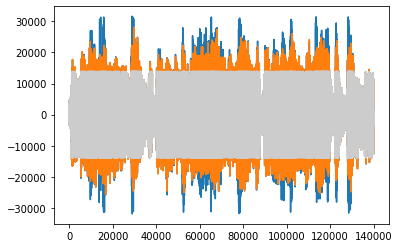

In [31]:
data_rec_pew_9, report_pew_9 = declip(
    data_clipped,
    shrinkage="PEW",
    start_lambda=0,
    stop_with_q=False,
    neighborhood_size=9,
)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 54 -- SDR = 20.865908735892948 -- dSDR = 5.865908735892948 -- SNRm = 12.4480893578731333
###### Declipping report (shrinkage=PEW) ######
Runtime: 13m28s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 20.866 dB.
SNR gain = 5.866 dB.
SNR miss = 12.448 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 20.866 dB.
SDR gain = 5.866 dB.


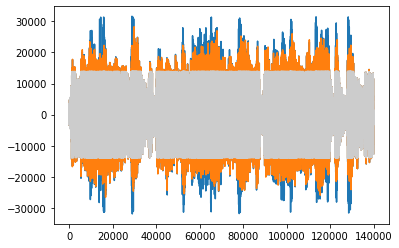

In [34]:
data_rec_pew_11, report_pew_11 = declip(
    data_clipped,
    shrinkage="PEW",
    start_lambda=0,
    stop_with_q=False,
    neighborhood_size=11,
)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 55 -- SDR = 20.778365257435105 -- dSDR = 5.778365257435105 -- SNRm = 12.5114297953457211
###### Declipping report (shrinkage=PEW) ######
Runtime: 15m33s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 20.778 dB.
SNR gain = 5.778 dB.
SNR miss = 12.511 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 20.778 dB.
SDR gain = 5.778 dB.


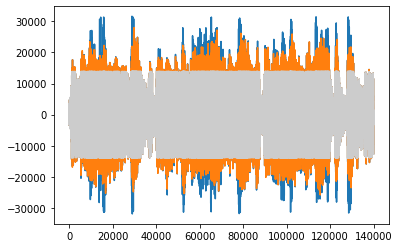

In [35]:
data_rec_pew_13, report_pew_13 = declip(
    data_clipped,
    shrinkage="PEW",
    start_lambda=0,
    stop_with_q=False,
    neighborhood_size=13,
)


Hold q to stop...
(10/10) lambda = 0.00010 -- it = 15 -- SDR = 20.512196323898806 -- dSDR = 5.512196323898806 -- SNRm = 12.7177052341378881
###### Declipping report (shrinkage=PEW) ######
Runtime: 15m51s
SNR of the clipped signal = 15.000 dB.
SNR of the reconstructed signal = 20.512 dB.
SNR gain = 5.512 dB.
SNR miss = 12.718 dB.
SDR of the clipped signal = 15.000 dB.
SDR of the reconstructed signal = 20.512 dB.
SDR gain = 5.512 dB.


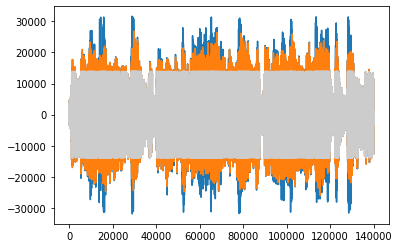

In [36]:
data_rec_pew_19, report_pew_19 = declip(
    data_clipped,
    shrinkage="PEW",
    start_lambda=0,
    stop_with_q=False,
    neighborhood_size=19,
)


We notice that a neighborhood of size 9 yields slightly better results, but the different isn't significant. We also notice that when going with bigger neighborhood beyond 9, we start to see a decrease in the performance. We conclude that going with neighborhood of size 7, as recommended in the paper, is the way to go. In the following sections, we'll be using a neighborhood of size 7

### More challenging scenario

In the early experiments, we saw Lasso getting outperformed by PEW especially when taking a lambda starting value of 1. However, Lasso algorithm was still able to preform well and recover sufficient part of the original audio signal. Here, we want to put both PEW and Lasso to the test under more challenging scenarios to see the actual difference in performance. We clips the audio signal to 7 SDR, much lower than the 15 SDR we used in the previous experiments.   

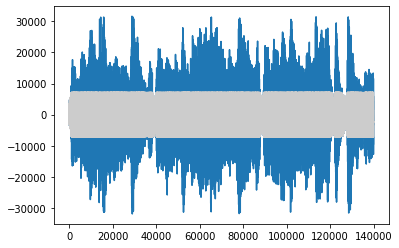

In [6]:
desired_sdr = 7
data_clipped_difficult, masks_difficult, clipping_threshold_difficult, true_sdr_difficult = clip_sdr(data, desired_sdr)

(10/10) lambda = 0.00010 -- it = 500 -- SDR = 8.56106115909516 -- dSDR = 1.5610611590951597 -- SNRm = 13.67928186069163715
###### Declipping report (shrinkage=L) ######
Runtime: 12m22s
SNR of the clipped signal = 7.000 dB.
SNR of the reconstructed signal = 8.561 dB.
SNR gain = 1.561 dB.
SNR miss = 13.679 dB.
SDR of the clipped signal = 7.000 dB.
SDR of the reconstructed signal = 8.561 dB.
SDR gain = 1.561 dB.


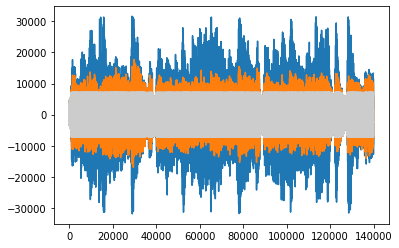

In [60]:
data_rec_l_difficult, report_l_difficult = declip(
    data_clipped_difficult,
    masks=masks_difficult,
    true_sdr=true_sdr_difficult,
    clipping_threshold=clipping_threshold_difficult,
    shrinkage="L",
    stop_with_q=False,
)


(10/10) lambda = 0.00010 -- it = 106 -- SDR = 17.113171840580137 -- dSDR = 10.113171840580137 -- SNRm = 2.3483618717460427
###### Declipping report (shrinkage=PEW) ######
Runtime: 13m57s
SNR of the clipped signal = 7.000 dB.
SNR of the reconstructed signal = 17.113 dB.
SNR gain = 10.113 dB.
SNR miss = 2.348 dB.
SDR of the clipped signal = 7.000 dB.
SDR of the reconstructed signal = 17.113 dB.
SDR gain = 10.113 dB.


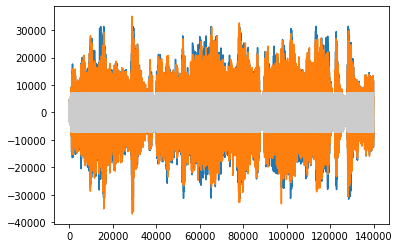

In [61]:
data_rec_pew_difficult, report_pew_difficult = declip(
    data_clipped_difficult,
    masks=masks_difficult,
    true_sdr=true_sdr_difficult,
    clipping_threshold=clipping_threshold_difficult,
    shrinkage="PEW",
    start_lambda=1,
    stop_with_q=False,
)

We notice here the actual difference of the Lasso and PEW. Under a more difficult scenario, Lasso wasn't able to reconstruct that much of the clipped signal, whereas PEW still impressively recovered almost all the original signal. 

### Testing the limits of the algorithm

Let's now use all the best settings we got (PEW, lambda starting value of 1, neighborhood of size 7), and put the algorithm to the test under a extreme scenarios to test its limits. 

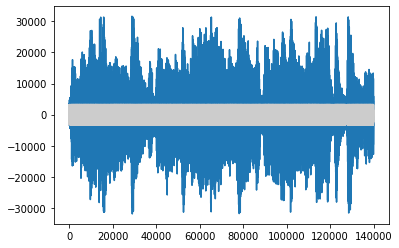

In [7]:
desired_sdr = 3
data_clipped_extreme, masks_extreme, clipping_threshold_extreme, true_sdr_extreme = clip_sdr(data, desired_sdr)

(10/10) lambda = 0.00010 -- it = 500 -- SDR = 9.360415971615263 -- dSDR = 6.360415971615263 -- SNRm = -3.635237344504394473
###### Declipping report (shrinkage=PEW) ######
Runtime: 15m10s
SNR of the clipped signal = 3.000 dB.
SNR of the reconstructed signal = 9.360 dB.
SNR gain = 6.360 dB.
SNR miss = -3.635 dB.
SDR of the clipped signal = 3.000 dB.
SDR of the reconstructed signal = 9.360 dB.
SDR gain = 6.360 dB.


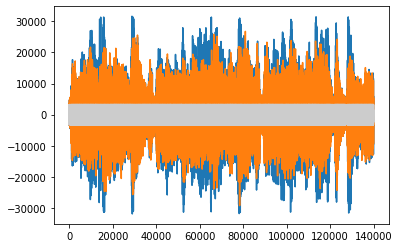

In [66]:
data_rec_pew_extreme, report_pew_extreme = declip(
    data_clipped_extreme,
    masks=masks_extreme,
    true_sdr=true_sdr_extreme,
    clipping_threshold=clipping_threshold_extreme,
    shrinkage="PEW",
    start_lambda=1,
    stop_with_q=False,
)

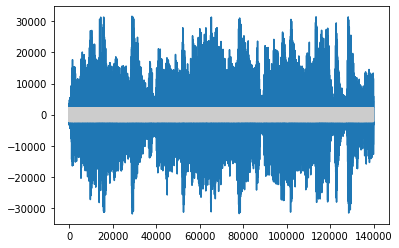

In [8]:
desired_sdr = 2
data_clipped_crazy, masks_crazy, clipping_threshold_crazy, true_sdr_crazy = clip_sdr(data, desired_sdr)

(10/10) lambda = 0.00010 -- it = 500 -- SDR = 6.976346179855396 -- dSDR = 4.976346179855397 -- SNRm = -5.981930094946567457
###### Declipping report (shrinkage=PEW) ######
Runtime: 16m50s
SNR of the clipped signal = 2.000 dB.
SNR of the reconstructed signal = 6.976 dB.
SNR gain = 4.976 dB.
SNR miss = -5.982 dB.
SDR of the clipped signal = 2.000 dB.
SDR of the reconstructed signal = 6.976 dB.
SDR gain = 4.976 dB.


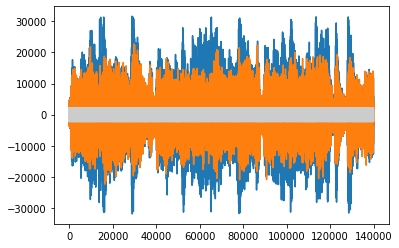

In [72]:
data_rec_pew_crazy, report_pew_crazy = declip(
    data_clipped_crazy,
    masks=masks_crazy,
    true_sdr=true_sdr_crazy,
    clipping_threshold=clipping_threshold_crazy,
    shrinkage="PEW",
    start_lambda=1,
    stop_with_q=False,
)

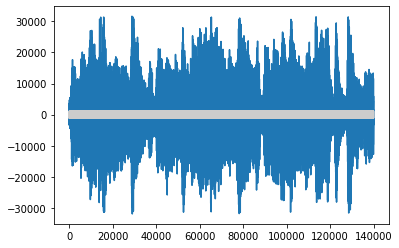

In [9]:
desired_sdr = 1
data_clipped_impossible, masks_impossible, clipping_threshold_impossible, true_sdr_impossible = clip_sdr(data, desired_sdr)

(10/10) lambda = 0.00010 -- it = 2 -- SDR = 4.359465782364217 -- dSDR = 3.3594657823642144 -- SNRm = -9.2852856054552024795
###### Declipping report (shrinkage=PEW) ######
Runtime: 15m47s
SNR of the clipped signal = 1.000 dB.
SNR of the reconstructed signal = 4.359 dB.
SNR gain = 3.359 dB.
SNR miss = -9.285 dB.
SDR of the clipped signal = 1.000 dB.
SDR of the reconstructed signal = 4.359 dB.
SDR gain = 3.359 dB.


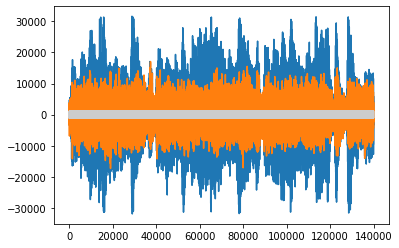

In [85]:
data_rec_pew_impossible, report_pew_impossible = declip(
    data_clipped_impossible,
    masks=masks_impossible,
    true_sdr=true_sdr_impossible,
    clipping_threshold=clipping_threshold_impossible,
    shrinkage="PEW",
    start_lambda=1,
    stop_with_q=False,
)

(10/10) lambda = 0.00010 -- it = 6 -- SDR = 4.941324347183965 -- dSDR = 3.9413243471839623 -- SNRm = -10.41014102755708329585
###### Declipping report (shrinkage=PEW) ######
Runtime: 14m26s
SNR of the clipped signal = 1.000 dB.
SNR of the reconstructed signal = 4.941 dB.
SNR gain = 3.941 dB.
SNR miss = -10.410 dB.
SDR of the clipped signal = 1.000 dB.
SDR of the reconstructed signal = 4.941 dB.
SDR gain = 3.941 dB.


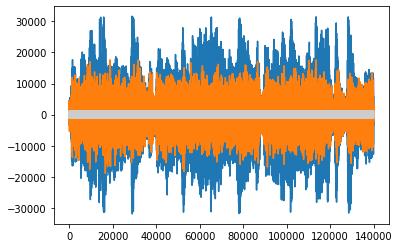

In [87]:
data_rec_pew_impossible_lambda2, report_pew_impossible_lambda2 = declip(
    data_clipped_impossible,
    masks=masks_impossible,
    true_sdr=true_sdr_impossible,
    clipping_threshold=clipping_threshold_impossible,
    shrinkage="PEW",
    start_lambda=2,
    stop_with_q=False,
)